In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print("done")

done


In [7]:
base_dir = r"C:\Users\Vishal\task2\cell_images\cell_images"
DATASET_DIR = base_dir
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
print("Parasitized images:", len(os.listdir(os.path.join(DATASET_DIR, "Parasitized"))))
print("Uninfected images:", len(os.listdir(os.path.join(DATASET_DIR, "Uninfected"))))

Parasitized images: 13779
Uninfected images: 13779


In [5]:
corrupted_files = []

for cls in ["Parasitized", "Uninfected"]:
    cls_path = os.path.join(DATASET_DIR, cls)
    for img in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img)
        try:
            Image.open(img_path).verify()
        except Exception as e:
            corrupted_files.append(img_path)

print("Corrupted images found:", len(corrupted_files))

for img_path in corrupted_files:
    os.remove(img_path)


Corrupted images found: 0


In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    validation_split=0.30   # 70% train, 30% temp
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.50   # 15% val, 15% test
)


In [9]:
train_gen = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True
)


Found 19292 images belonging to 2 classes.


In [10]:
val_gen = val_test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=False
)


Found 13780 images belonging to 2 classes.


In [11]:
test_gen = val_test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)
print(train_gen.class_indices)


Found 13778 images belonging to 2 classes.
{'Parasitized': 0, 'Uninfected': 1}


In [12]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="sensitivity"),
        tf.keras.metrics.Precision(name="precision")
    ]
)


In [15]:
callbacks = [
    EarlyStopping(
        monitor="val_sensitivity",
        patience=5,
        mode="max",
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_malaria_model.h5",
        monitor="val_sensitivity",
        mode="max",
        save_best_only=True
    )
]
print("done")

done


In [16]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8361 - loss: 0.3674 - precision: 0.8363 - sensitivity: 0.8288

603/603 ━━━━━━━━━━━━━━━━━━━━ 1160s 2s/step - accuracy: 0.8847 - loss: 0.2864 - precision: 0.8844 - sensitivity: 0.8851 - val_accuracy: 0.8891 - val_loss: 0.2666 - val_precision: 0.8346 - val_sensitivity: 0.9705
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1162s 2s/step - accuracy: 0.9260 - loss: 0.2056 - precision: 0.9200 - sensitivity: 0.9331 - val_accuracy: 0.9202 - val_loss: 0.2071 - val_precision: 0.8919 - val_sensitivity: 0.9563
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9298 - loss: 0.1914 - precision: 0.9256 - sensitivity: 0.9347

603/603 ━━━━━━━━━━━━━━━━━━━━ 1124s 2s/step - accuracy: 0.9305 - loss: 0.1891 - precision: 0.9258 - sensitivity: 0.9361 - val_accuracy: 0.9091 - val_loss: 0.2291 - val_precision: 0.8612 - val_sensitivity: 0.9755
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1161s 2s/step - accuracy: 0.9359 - loss: 0.1766 - precision: 0.9299 - sensitivity: 0.9430 - val_accuracy: 0.9187 - val_loss: 0.2088 - val_precision: 0.8779 - val_sensitivity: 0.9727
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1290s 2s/step - accuracy: 0.9363 - loss: 0.1718 - precision: 0.9285 - sensitivity: 0.9455 - val_accuracy: 0.9275 - val_loss: 0.1894 - val_precision: 0.8991 - val_sensitivity: 0.9631


In [17]:
for layer in base_model.layers[-40:]:
    layer.trainable = True


In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="sensitivity"),
        tf.keras.metrics.Precision(name="precision")
    ]
)


In [19]:
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1457s 2s/step - accuracy: 0.9240 - loss: 0.2082 - precision: 0.9238 - sensitivity: 0.9241 - val_accuracy: 0.9346 - val_loss: 0.1839 - val_precision: 0.9106 - val_sensitivity: 0.9639
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1401s 2s/step - accuracy: 0.9414 - loss: 0.1683 - precision: 0.9338 - sensitivity: 0.9502 - val_accuracy: 0.9368 - val_loss: 0.1691 - val_precision: 0.9064 - val_sensitivity: 0.9742
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1403s 2s/step - accuracy: 0.9464 - loss: 0.1545 - precision: 0.9372 - sensitivity: 0.9568 - val_accuracy: 0.9397 - val_loss: 0.1610 - val_precision: 0.9108 - val_sensitivity: 0.9749
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1494s 2s/step - accuracy: 0.9468 - loss: 0.1495 - precision: 0.9363 - sensitivity: 0.9588 - val_accuracy: 0.9465 - val_loss: 0.1487 - val_precision: 0.9243 - val_sensitivity: 0.9727
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1633s 3s/step - accuracy: 0.9475 - loss: 0.1439 - precision: 0.9377 - sensiti

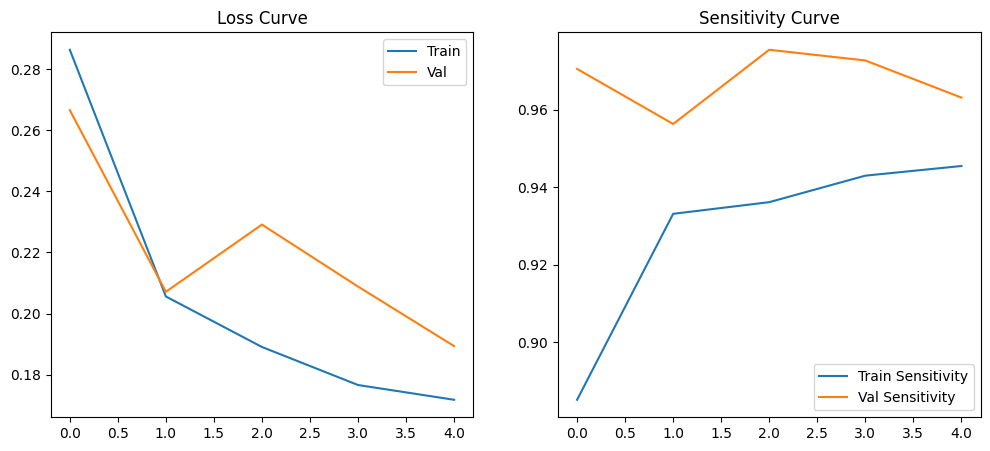

In [20]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["sensitivity"], label="Train Sensitivity")
plt.plot(history.history["val_sensitivity"], label="Val Sensitivity")
plt.title("Sensitivity Curve")
plt.legend()

plt.show()


In [21]:
y_true = test_gen.classes
y_probs = model.predict(test_gen)
y_pred = (y_probs > 0.5).astype(int)


431/431 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step


In [22]:
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[6299  590]
 [ 251 6638]]


In [23]:
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


Sensitivity: 0.9635651037886486
Specificity: 0.9143562200609667


In [24]:
print(classification_report(y_true, y_pred, target_names=["Parasitized", "Uninfected"]))


              precision    recall  f1-score   support

 Parasitized       0.96      0.91      0.94      6889
  Uninfected       0.92      0.96      0.94      6889

    accuracy                           0.94     13778
   macro avg       0.94      0.94      0.94     13778
weighted avg       0.94      0.94      0.94     13778



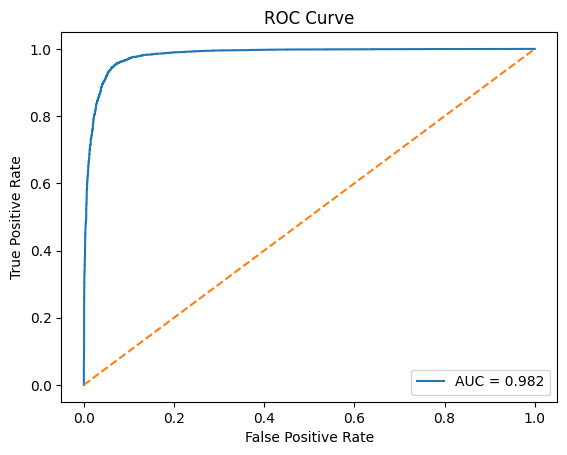

In [25]:
roc_auc = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


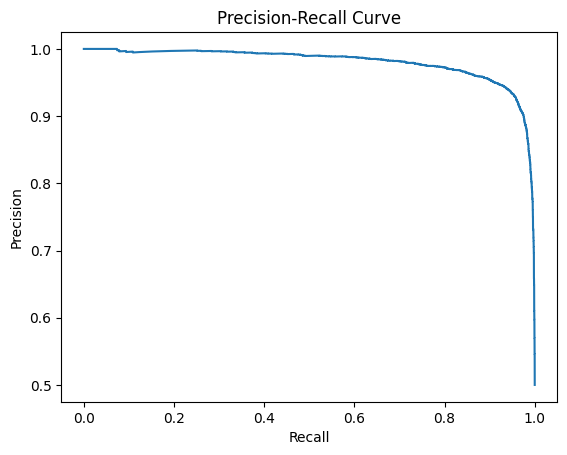

In [26]:
precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [27]:
thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    preds = (y_probs > t).astype(int)
    cm = confusion_matrix(y_true, preds)
    TN, FP, FN, TP = cm.ravel()
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    print(f"Threshold {t:.2f} → Sensitivity: {sens:.3f}, Specificity: {spec:.3f}")


Threshold 0.10 → Sensitivity: 0.993, Specificity: 0.753
Threshold 0.15 → Sensitivity: 0.990, Specificity: 0.798
Threshold 0.20 → Sensitivity: 0.986, Specificity: 0.829
Threshold 0.25 → Sensitivity: 0.983, Specificity: 0.852
Threshold 0.30 → Sensitivity: 0.981, Specificity: 0.870
Threshold 0.35 → Sensitivity: 0.977, Specificity: 0.883
Threshold 0.40 → Sensitivity: 0.974, Specificity: 0.895
Threshold 0.45 → Sensitivity: 0.968, Specificity: 0.904
Threshold 0.50 → Sensitivity: 0.964, Specificity: 0.914
Threshold 0.55 → Sensitivity: 0.958, Specificity: 0.924
Threshold 0.60 → Sensitivity: 0.950, Specificity: 0.933
Threshold 0.65 → Sensitivity: 0.941, Specificity: 0.940
Threshold 0.70 → Sensitivity: 0.928, Specificity: 0.946
Threshold 0.75 → Sensitivity: 0.908, Specificity: 0.953
Threshold 0.80 → Sensitivity: 0.874, Specificity: 0.963
Threshold 0.85 → Sensitivity: 0.795, Specificity: 0.978


In [ ]:
## Error Analysis and Misclassification Study
#An error analysis was conducted by visualizing misclassified test samples. These samples were intentionally selected using a mismatch between true and predicted labels to better understand model limitations. Despite achieving high overall performance (≈94% accuracy), a small subset of errors was observed.

#Most misclassifications corresponded to borderline probability scores close to the decision threshold, indicating model uncertainty. Visual inspection revealed that these cases often contained low-contrast images or subtle parasitic features that were difficult to distinguish from background artifacts. This highlights the inherent challenges of microscopy-based malaria diagnosis.
#To reduce false negatives, which are critical in medical screening tasks, a lower decision threshold (0.40) was applied instead of the default 0.50. This adjustment increased sensitivity at the cost of a small reduction in specificity, aligning the model behavior with clinical priorities where missing an infected sample is riskier than a false alarm.
#The visualized samples represent only misclassified cases and were not randomly selected; therefore, all displayed examples are expected to be incorrect predictions by design.


431/431 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step


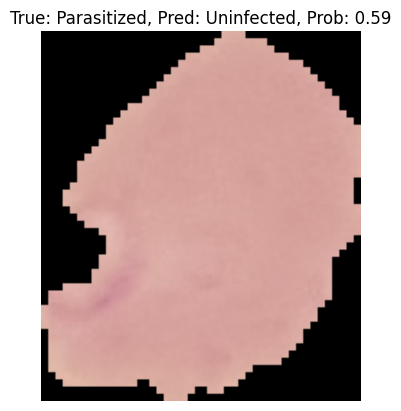

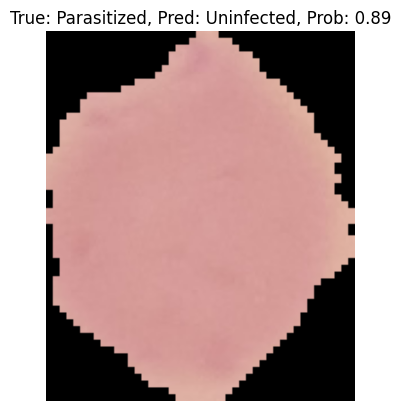

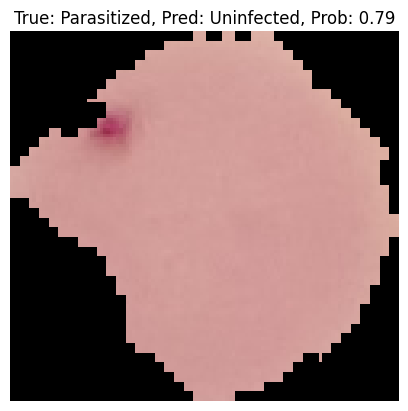

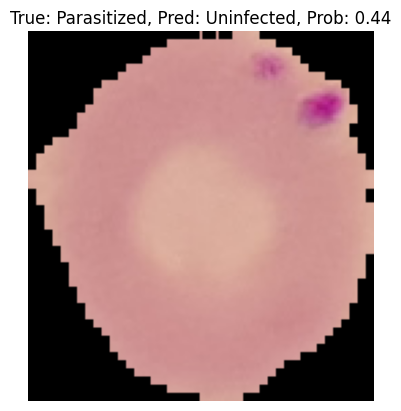

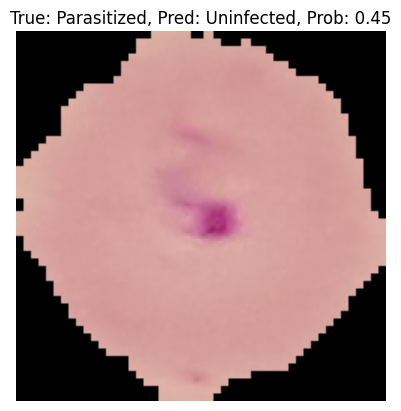

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# True labels
y_true = test_gen.classes

# Predicted probabilities + threshold
y_probs = model.predict(test_gen).ravel()
THRESHOLD = 0.40
y_pred = (y_probs >= THRESHOLD).astype(int)

# Label mapping
label_map = {0: "Parasitized", 1: "Uninfected"}

# Misclassified indices
mis_idx = np.where(y_true != y_pred)[0]

# Show first 5 misclassifications
for i in mis_idx[:5]:
    img_path = test_gen.filepaths[i]
    img = Image.open(img_path)

    plt.imshow(img)
    plt.title(
        f"True: {label_map[y_true[i]]}, "
        f"Pred: {label_map[y_pred[i]]}, "
        f"Prob: {y_probs[i]:.2f}"
    )
    plt.axis("off")
    plt.show()


In [ ]:
#Threshold optimization was performed to balance sensitivity and specificity. A threshold of 0.40 was selected as it achieves a sensitivity of 97.4%, minimizing false negatives, while maintaining a specificity of 89.5%, which satisfies operational constraints. Given the high clinical cost of missing malaria infections, sensitivity was prioritized over specificity.